In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42

# Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Basic Preprocessing

In [3]:
# Droping duplicates as important for LOF distance calculations)
df = df.drop_duplicates()

# Separating features and labels
X = df.drop(columns=["Class"])
y = df["Class"]

# Standardize=ing with non-robust features as LOF uses distance metrics
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Estimate Contamination

In [4]:
contamination = y.mean() 
print("Contamination:", contamination)

Contamination: 0.001667101358352777


# Fit the LOF Model

In [5]:
lof = LocalOutlierFactor(
    n_neighbors=20,        
    contamination=contamination,
    novelty=False,  
    metric="euclidean"     
)

y_pred = lof.fit_predict(X_scaled)

y_pred_binary = (y_pred == -1).astype(int)

# Anomaly Scores

In [6]:
scores = -lof.negative_outlier_factor_  

df_results = df.copy()
df_results["lof_score"] = scores
df_results["predicted_anomaly"] = y_pred_binary
df_results.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,lof_score,predicted_anomaly
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.112870,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.668085,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.321607,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.212563,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.298436,0


# Evaluation

In [7]:
print(classification_report(y, y_pred_binary))

auc = roc_auc_score(y, scores)
print("ROC-AUC (scores):", auc)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    283253
           1       0.00      0.00      0.00       473

    accuracy                           1.00    283726
   macro avg       0.50      0.50      0.50    283726
weighted avg       1.00      1.00      1.00    283726

ROC-AUC (scores): 0.5134545335720568


# Visualizations

## LOF Score Distribution

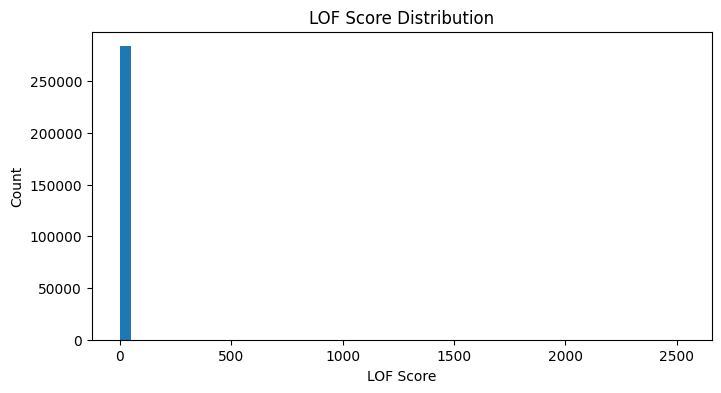

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(scores, bins=50)
plt.title("LOF Score Distribution")
plt.xlabel("LOF Score")
plt.ylabel("Count")
plt.show()

## Scatter Plot (PCA for 2D projection)

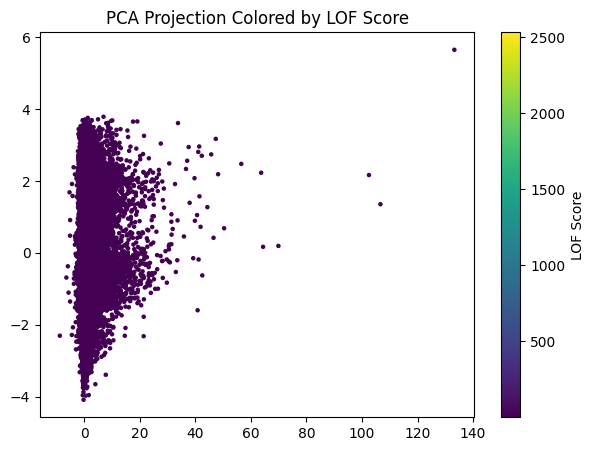

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=scores, cmap="viridis", s=5)
plt.colorbar(label="LOF Score")
plt.title("PCA Projection Colored by LOF Score")
plt.show()

## ROC Curve Based on LOF Scores

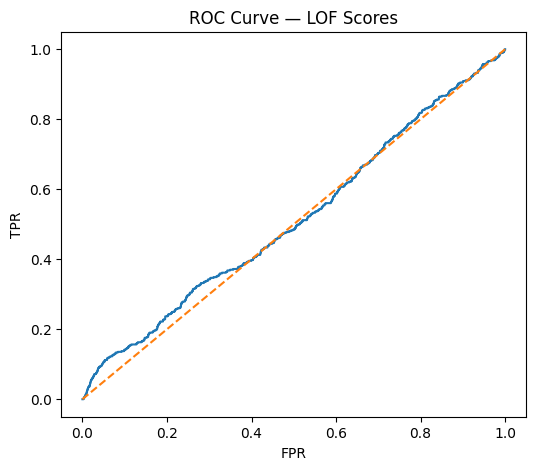

In [10]:
fpr, tpr, thresholds = roc_curve(y, scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve — LOF Scores")
plt.show()

# Save Results

In [11]:
output_path = "lof_results.csv"
df_results.to_csv(output_path, index=False)
print("Saved:", output_path)

Saved: lof_results.csv
